In [5]:
#LAB-RGB conversions
import torchvision
import torch

def preprocess_lab(lab):
		# L_chan: black and white with input range [0, 100]
		# a_chan/b_chan: color channels with input range ~[-110, 110], not exact
		# [0, 100] => [-1, 1],  ~[-110, 110] => [-1, 1]
		scale = torch.tensor([50,110,110]).reshape([1,1,1,3])
		offset = torch.tensor([-1,0,0]).reshape([1,1,1,3])
		return lab/scale + offset

def deprocess_lab(labp):
		scale = torch.tensor([50,110,110]).reshape([1,1,1,3])
		offset = torch.tensor([-1,0,0]).reshape([1,1,1,3])
		lab = (labp - offset)*scale
		return lab

def rgb_to_lab(srgb):

	srgb_pixels = torch.reshape(srgb, [-1, 3])

	linear_mask = (srgb_pixels <= 0.04045).type(torch.FloatTensor)
	exponential_mask = (srgb_pixels > 0.04045).type(torch.FloatTensor)
	rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask

	rgb_to_xyz = torch.tensor([
				#    X        Y          Z
				[0.412453, 0.212671, 0.019334], # R
				[0.357580, 0.715160, 0.119193], # G
				[0.180423, 0.072169, 0.950227], # B
			]).type(torch.FloatTensor)

	xyz_pixels = torch.mm(rgb_pixels, rgb_to_xyz)


	# XYZ to Lab
	xyz_normalized_pixels = torch.mul(xyz_pixels, torch.tensor([1/0.950456, 1.0, 1/1.088754]).type(torch.FloatTensor))

	epsilon = 6.0/29.0

	linear_mask = (xyz_normalized_pixels <= (epsilon**3)).type(torch.FloatTensor)

	exponential_mask = (xyz_normalized_pixels > (epsilon**3)).type(torch.FloatTensor)

	fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4.0/29.0) * linear_mask + ((xyz_normalized_pixels+0.000001) ** (1.0/3.0)) * exponential_mask
	# convert to lab
	fxfyfz_to_lab = torch.tensor([
		#  l       a       b
		[  0.0,  500.0,    0.0], # fx
		[116.0, -500.0,  200.0], # fy
		[  0.0,    0.0, -200.0], # fz
	]).type(torch.FloatTensor)
	lab_pixels = torch.mm(fxfyfz_pixels, fxfyfz_to_lab) + torch.tensor([-16.0, 0.0, 0.0]).type(torch.FloatTensor)
	#return tf.reshape(lab_pixels, tf.shape(srgb))
	return preprocess_lab(torch.reshape(lab_pixels, srgb.shape))

def lab_to_rgb(labp):
		lab = deprocess_lab(labp)
		lab_pixels = torch.reshape(lab, [-1, 3])
		# convert to fxfyfz
		lab_to_fxfyfz = torch.tensor([
			#   fx      fy        fz
			[1/116.0, 1/116.0,  1/116.0], # l
			[1/500.0,     0.0,      0.0], # a
			[    0.0,     0.0, -1/200.0], # b
		]).type(torch.FloatTensor)
		fxfyfz_pixels = torch.mm(lab_pixels + torch.tensor([16.0, 0.0, 0.0]).type(torch.FloatTensor), lab_to_fxfyfz)

		# convert to xyz
		epsilon = 6.0/29.0
		linear_mask = (fxfyfz_pixels <= epsilon).type(torch.FloatTensor)
		exponential_mask = (fxfyfz_pixels > epsilon).type(torch.FloatTensor)


		xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29.0)) * linear_mask + ((fxfyfz_pixels+0.000001) ** 3) * exponential_mask

		# denormalize for D65 white point
		xyz_pixels = torch.mul(xyz_pixels, torch.tensor([0.950456, 1.0, 1.088754]).type(torch.FloatTensor))

		xyz_to_rgb = torch.tensor([
			#     r           g          b
			[ 3.2404542, -0.9692660,  0.0556434], # x
			[-1.5371385,  1.8760108, -0.2040259], # y
			[-0.4985314,  0.0415560,  1.0572252], # z
		]).type(torch.FloatTensor)

		rgb_pixels =  torch.mm(xyz_pixels, xyz_to_rgb)
		# avoid a slightly negative number messing up the conversion
		#clip
		rgb_pixels[rgb_pixels > 1] = 1
		rgb_pixels[rgb_pixels < 0] = 0

		linear_mask = (rgb_pixels <= 0.0031308).type(torch.FloatTensor)
		exponential_mask = (rgb_pixels > 0.0031308).type(torch.FloatTensor)
		srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + (((rgb_pixels+0.000001) ** (1/2.4) * 1.055) - 0.055) * exponential_mask

		srgb_pixels[srgb_pixels>1]=1
		srgb_pixels[srgb_pixels<0]=0

		return torch.reshape(srgb_pixels, lab.shape)

In [65]:
import math
import torch
import torch.nn as nn
# import torch.nn.functional as F
import numpy as np

class linear(nn.Module):

  def __init__(self):
    super(linear, self).__init__()
    self.linear1 = nn.Linear(in_features=32*32, out_features=100)
    self.linear2 = nn.Linear(in_features=100, out_features=32*32*2)
    self.PATH = '/content/drive/MyDrive/HW04/linear.pt'

  def f(self, L):
    return self.linear1(L)

  def g(self, L):
    return self.linear2(L)

  def loss(self, L, AB):
    N = L.shape[0]
    AB_hat = self.predict(L)
    diff = AB_hat-AB
    loss = 1/N * torch.sum(torch.square(diff))
    return loss

  def fit(self, L, AB):
    # Defining hyper-parameters
    epochs= 10000
    learning_rate = 0.0005
    optimizer = torch.optim.Adam(self.parameters(), learning_rate)
    conv_tol=0.0000000001

    losses = []
    prev_loss = np.infty
    for epoch in range(epochs):
      optimizer.zero_grad()
      loss = self.loss(L, AB)
      loss.backward()
      optimizer.step()
      print(f"{epoch} {loss.item()}")
      losses.append(loss.item())
      if (epoch%100 == 0):
        self.save()
      if (abs(loss.item()-prev_loss) <= conv_tol):
        break;
      prev_loss = loss.item()
    return losses

  def predict(self, L):
    f = self.f(L)
    g = self.g(f)
    return g

  def save(self):
    torch.save({"model_state_dict": self.state_dict()}, self.PATH)

  def load(self):
    checkpoint = torch.load(self.PATH)
    self.load_state_dict(checkpoint["model_state_dict"])

In [66]:
import torch

def train(model, device, L, AB):
  L = L.flatten(start_dim=1)
  AB = AB.flatten(start_dim=1)

  # Randomly shuffle the training set
  idx = torch.randperm(L.shape[0])
  L_shuffled = L[idx, :]
  AB_shuffled = AB[idx]

  model.train()
  losses = model.fit(L_shuffled.to(device), AB_shuffled.to(device))
  return losses

def predict(model, device, L):
  L = L.flatten(start_dim=1)
  with torch.no_grad():
    return model.predict(L.to(device)).view((-1, 32, 32, 2))

def test(pred_RGB, RGB):
  return nn.MSELoss()(pred_RGB, RGB).item()

Streaming output truncated to the last 5000 lines.
5000 28.9085750579834
5001 28.908296585083008
5002 28.90873908996582
5003 28.907089233398438
5004 28.907169342041016
5005 28.907114028930664
5006 28.90696144104004
5007 28.90630340576172
5008 28.90605354309082
5009 28.905811309814453
5010 28.90607452392578
5011 28.90552520751953
5012 28.905248641967773
5013 28.905134201049805
5014 28.904972076416016
5015 28.905075073242188
5016 28.904659271240234
5017 28.9046688079834
5018 28.904417037963867
5019 28.904464721679688
5020 28.904388427734375
5021 28.904170989990234
5022 28.90406608581543
5023 28.904098510742188
5024 28.904022216796875
5025 28.903900146484375
5026 28.903789520263672
5027 28.903717041015625
5028 28.90375518798828
5029 28.903644561767578
5030 28.903575897216797
5031 28.903575897216797
5032 28.90348243713379
5033 28.90349006652832
5034 28.903470993041992
5035 28.903486251831055
5036 28.903493881225586
5037 28.903573989868164
5038 28.903701782226562
5039 28.903968811035156
504

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50000, 32, 32, 3])) that is different to the input size (torch.Size([1, 32, 32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


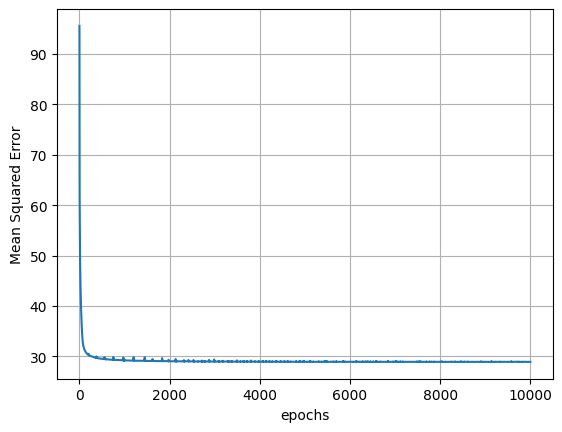

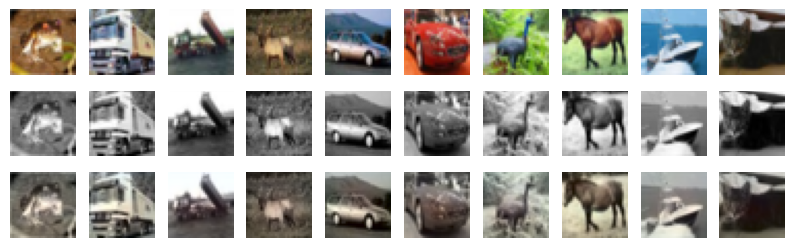

train error =  1.1484440341591835


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 32, 32, 3])) that is different to the input size (torch.Size([1, 32, 32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


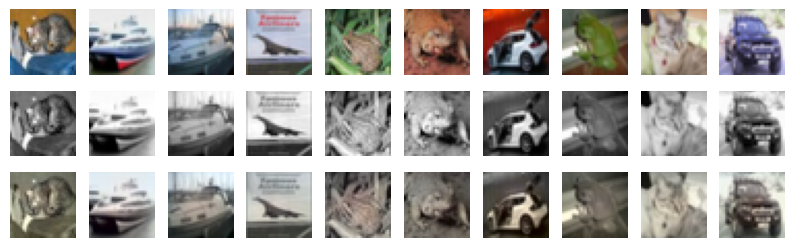

test error =  0.9851570576429367


In [67]:
import numpy as np
import torch
# import colorspaces
import matplotlib.pyplot as plt

# data = np.load("../data/ae_data.npz") #Load data
data = np.load("/content/drive/MyDrive/HW04/data/ae_data.npz")

#Extract train data
RGBtr = torch.tensor(data["RGBtr"])
Ltr   = torch.tensor(data["Ltr"])
ABtr  = torch.tensor(data["ABtr"])

print("RGBtr shape = ", RGBtr.shape)
print("Ltr shape = ", Ltr.shape)
print("ABtr shape = ", ABtr.shape)

#Extract test data
RGBte = torch.tensor(data["RGBte"])
Lte   = torch.tensor(data["Lte"])
ABte  = torch.tensor(data["ABte"])

print("RGBte shape = ", RGBte.shape)
print("Lte shape = ", Lte.shape)
print("ABte shape = ", ABte.shape)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

# Initialize the model and move the model and data to the device
model = linear()
model = model.to(device)

# Train the model
losses = train(model, device, Ltr, ABtr)
x = range(len(losses))
plt.plot(x, losses)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
# descent_per_optimizer[optimizer_names[j]] = losses

# Save the model params
model.save()

# Predict on the training set
pred_ABtr = predict(model, device, Ltr)
pred_LABtr = torch.cat((Ltr[:,:,:,None],pred_ABtr.to("cpu")),dim=3)
train_error = 0

plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBtr[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(`cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBtr = lab_to_rgb(pred_LABtr[i,:,:,:])
    train_error += test(pred_RGBtr, RGBtr)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBtr[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Train error
print("train error = ", train_error)

# Predict on the test set
pred_ABte = predict(model, device, Lte)
pred_LABte = torch.cat((Lte[:,:,:,None],pred_ABte.to("cpu")),dim=3)
test_error = 0

#Plot true and predicted RGB images
plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBte[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Lte[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBte = lab_to_rgb(pred_LABte[i,:,:,:])
    test_error += test(pred_RGBte, RGBte)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBte[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Test error
print("test error = ", test_error)

In [68]:
model.save()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50000, 32, 32, 3])) that is different to the input size (torch.Size([1, 32, 32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


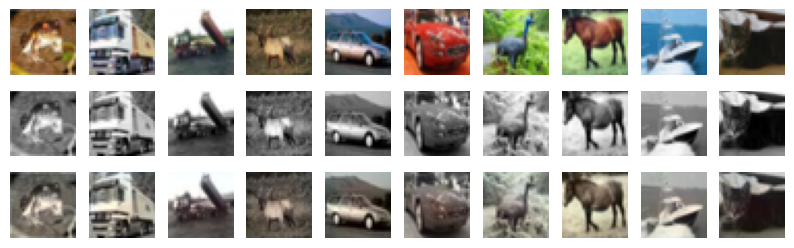

In [16]:
# Predict on the training set
pred_ABtr = predict(model, device, Ltr)
pred_LABtr = torch.cat((Ltr[:,:,:,None],pred_ABtr.to("cpu")),dim=3)
train_error = 0

plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBtr[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Ltr[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBtr = lab_to_rgb(pred_LABtr[i,:,:,:])
    train_error += test(pred_RGBtr, RGBtr)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBtr[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 32, 32, 3])) that is different to the input size (torch.Size([1, 32, 32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


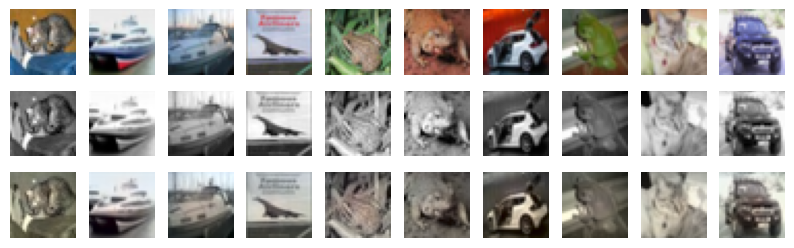

test error =  0.9861284419894218


In [ ]:
# Predict on the test set
pred_ABte = predict(model, device, Lte)
pred_LABte = torch.cat((Lte[:,:,:,None],pred_ABte.to("cpu")),dim=3)
test_error = 0

#Plot true and predicted RGB images
plt.figure(figsize=(10,3))
for i in range(10):

    #Plot true image
    plt.subplot(3,10,i+1)
    plt.imshow(RGBte[i,:,:,:])
    plt.axis(False)

    #Plot L channel
    plt.subplot(3,10,i+11)
    plt.imshow(Lte[i,:,:],cmap="gray")
    plt.axis(False)

    #Convert LAB prediction to RGB and plot
    pred_RGBte = lab_to_rgb(pred_LABte[i,:,:,:])
    test_error += test(pred_RGBte, RGBte)
    plt.subplot(3,10,i+21)
    plt.imshow(pred_RGBte[0,:,:,:].detach().numpy())
    plt.axis(False)
plt.show()

# Test error
print("test error = ", test_error)

In [ ]:
# Hyper-parameter tuning
# Plot for different optimizers for fixed number of iterations
epochs_it = range(epochs)
plt.plot(epochs_it, descent_per_optimizer["Adam"], label="Adam")
plt.plot(epochs_it, descent_per_optimizer["Adadelta"], label="Adadelta")
plt.plot(epochs_it, descent_per_optimizer["SGD with momentum"], label="SGD with momentum")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()

for j in range(3):
  print(optimizer_names[j], "  ", train_errors[j])

In [7]:
def read_losses(file_name):
  losses = []
  with open(file_name, 'r') as fp:
      for line in fp:
          x = line[:-1]
          losses.append(float(x))

  return losses

def write_losses(file_name, losses):
  with open(file_name, 'w') as fp:
    for item in losses:
        fp.write("%s\n" % item)

adadelta_file = "/content/drive/MyDrive/HW04/adadelta_0.1.txt"
adagrad_file = "/content/drive/MyDrive/HW04/adagrad_0.1.txt"
adam_file = "/content/drive/MyDrive/HW04/adam_0.0005.txt"
sgd_file = "/content/drive/MyDrive/HW04/sgd.txt"

In [8]:
adadelta_loss = read_losses(adadelta_file)
print(adadelta_loss)
adam_loss = read_losses(adam_file)
sgd_loss = read_losses(sgd_file)
adagrad_loss = read_losses(adagrad_file)

[94.51268005371094, 80.8073501586914, 72.85856628417969, 67.86881256103516, 64.45475006103516, 61.98516845703125, 60.10111999511719, 58.60622787475586, 57.3679084777832, 56.316062927246094, 55.397438049316406, 54.583106994628906, 53.844425201416016, 53.16904830932617, 52.54169845581055, 51.95804214477539, 51.41083908081055, 50.90272521972656, 50.441158294677734, 50.034053802490234, 49.66375732421875, 49.31355285644531, 48.975929260253906, 48.643978118896484, 48.33089065551758, 48.021480560302734, 47.69207000732422, 47.332088470458984, 46.955474853515625, 46.574859619140625, 46.208133697509766, 45.8671989440918, 45.55345916748047, 45.2529296875, 44.94963455200195, 44.641048431396484, 44.330448150634766, 44.02534866333008, 43.73345947265625, 43.465518951416016, 43.22237777709961, 42.990692138671875, 42.76350784301758, 42.54644012451172, 42.34715270996094, 42.167789459228516, 42.02177429199219, 41.88056564331055, 41.73851776123047, 41.65776443481445, 41.695919036865234, 41.82181930541992,

In [9]:
adadelta_l = adadelta_loss[::100]
adam_l = adam_loss[::100]
sgd_l = sgd_loss[::100]
adagrad_l = adagrad_loss[::100]

In [24]:
adagrad_l

[96.48151397705078,
 850,
 820,
 800,
 777.9342041015625,
 633.7295532226562,
 535.0018920898438,
 462.9636535644531,
 408.025390625,
 364.73248291015625,
 329.74114990234375,
 300.8830871582031,
 276.6883544921875,
 256.1239013671875,
 238.44171142578125,
 223.08615112304688,
 209.63583374023438,
 197.76507568359375,
 187.21815490722656,
 177.79144287109375,
 169.3206329345703,
 161.6719207763672,
 154.73501586914062,
 148.41831970214844,
 142.6451416015625,
 137.35072326660156,
 132.48007202148438,
 127.98619842529297,
 123.82869720458984,
 119.97261810302734,
 116.38764953613281,
 113.04730987548828,
 109.92842102050781,
 107.01057434082031,
 104.27574920654297,
 101.70797729492188,
 99.29307556152344,
 97.01834106445312,
 94.8724594116211,
 92.84527587890625,
 90.92759704589844,
 89.11122131347656,
 87.3886489868164,
 85.75312042236328,
 84.1985092163086,
 82.71920013427734,
 81.31011962890625,
 79.9665756225586,
 78.68433380126953,
 77.4594497680664,
 76.28834533691406,
 75.167709

In [13]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Loss')

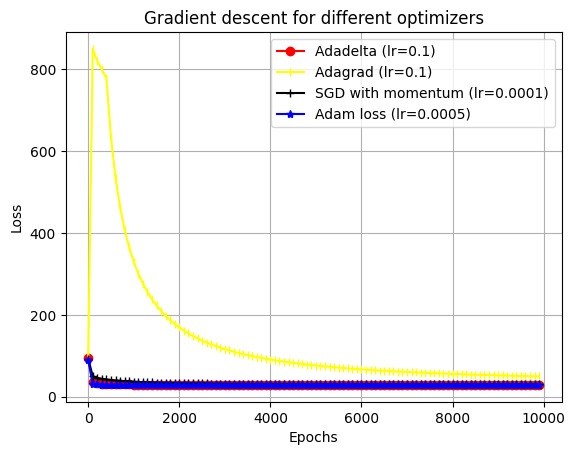

In [23]:
x = np.arange(len(adadelta_l))
plt.plot(x*100, adadelta_l, label="Adadelta (lr=0.1)", color='red', marker='o')
plt.plot(x*100, adagrad_l, label="Adagrad (lr=0.1)", color='yellow', marker='|')
plt.plot(x*100, sgd_l, label="SGD with momentum (lr=0.0001)", color='black', marker='+')
plt.plot(x*100, adam_l, label="Adam loss (lr=0.0005)", color='blue', marker='*')
plt.legend()
plt.grid()
plt.title("Gradient descent for different optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")